# Minimum Distance Travelled by Ambulance in a Day

Find the optimal position to place 6 ambulances within a day (3 hour interval) in which they will travel the least amount of distance. 

Notes
- Each ambulance is committed every three hours
- Ambulances travel within allocated "sectors"

In [1]:
# load required libraries
import pandas as pd
import numpy as np
import geopandas as gpd 

import contextily as ctx
import matplotlib.pyplot as plt
import time

# processing geojson files
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

# clustering + visualisation
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()

from scipy.spatial import Voronoi, voronoi_plot_2d


## Exploratory Data Analysis

Look into the characteristics of the data to pick up patterns for use in determining ambulance placement within the city of Nairobi. 

In [2]:

# load data
df = pd.read_csv('Train.csv', parse_dates=['datetime'])
print(df.shape)
df.head()

## Notes: The accidents identify areas where an ambulance must reach, creating a voronoi diagram gives us the central point of these accident 
# 1. visualize the accident points
# 2. time distribution of accidents
# 2. cluster the accidents
# 3. create voronoi diagram for the points


(6318, 4)


,uid,datetime,latitude,longitude
0,1,2018-01-01 00:25:46,-1.188850,36.931382
1,2,2018-01-01 02:02:39,-0.662939,37.208730
2,3,2018-01-01 02:31:49,-0.662939,37.208730
3,4,2018-01-01 03:04:01,-1.288087,36.826583
4,5,2018-01-01 03:58:49,-1.188850,36.931382


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:title={'center':'Crash Locations'}, xlabel='longitude', ylabel='latitude'>

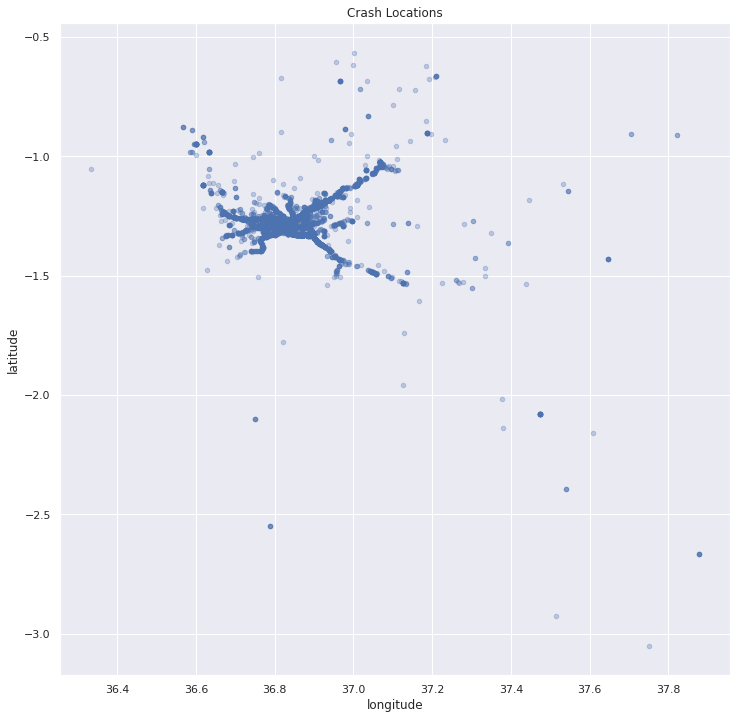

In [3]:
# Plot the crashes
df.plot(x='longitude', y='latitude', kind='scatter', figsize=(12, 12), alpha=0.3, title='Crash Locations')

Text(0.5, 1.0, 'Accident Distribution per 3Hours')

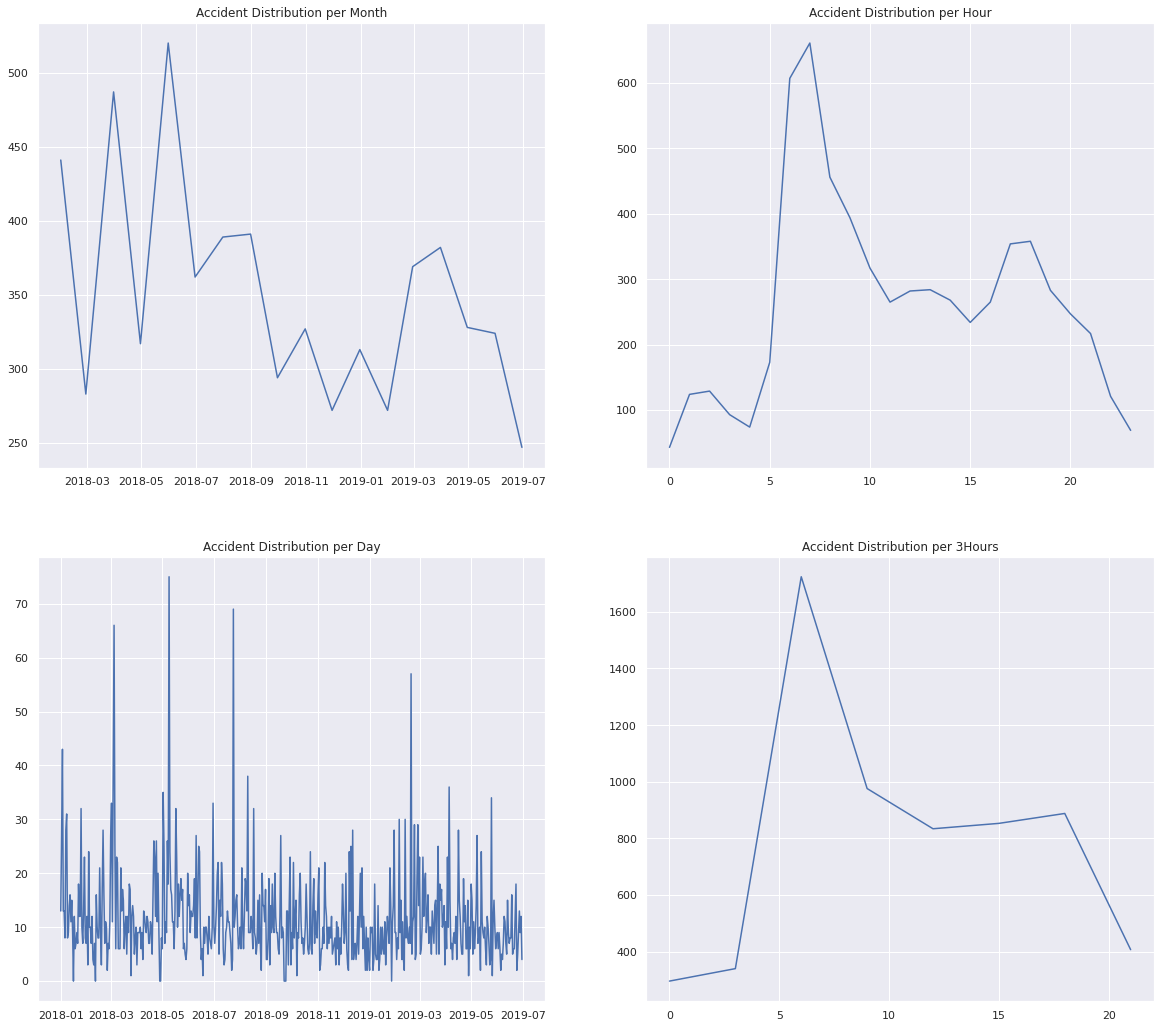

In [5]:
# 2. timeline

## per month
df['idx'] = 1
df['hour'] = df['datetime'].dt.hour

df_month = df.resample('M', on='datetime')['idx'].count().reset_index()
df_pd_month = pd.DataFrame(df_month)

## per day
df_day = df.resample('D', on='datetime')['idx'].count().reset_index()
df_pd_day = pd.DataFrame(df_day)

## per hour
df_hour = df.groupby('hour').count().reset_index()
df_pd_hour = pd.DataFrame(df_hour)

## per 3 hours
df_3hours = df.resample('3H', on='datetime')['idx'].count().reset_index()
df_3hours['datetime'] = df_3hours['datetime'].dt.hour

df_3hours = df_3hours.groupby('datetime').sum().reset_index()
df_pd_3hours = pd.DataFrame(df_3hours)

#---- axes
x_day = df_pd_day['datetime']
y_day = df_pd_day['idx']

x_month = df_pd_month['datetime']
y_month = df_pd_month['idx']

x_hour = df_pd_hour['hour']
y_hour = df_pd_hour['idx']

x_3hours = df_pd_3hours['datetime']
y_3hours = df_pd_3hours['idx']

fig, axs = plt.subplots(2, 2,figsize=(20, 18))

axs[0, 0].plot(x_month, y_month)
axs[0, 0].set_title("Accident Distribution per Month")

axs[1, 0].plot(x_day, y_day)
axs[1, 0].set_title("Accident Distribution per Day")

axs[0, 1].plot(x_hour, y_hour)
axs[0, 1].set_title("Accident Distribution per Hour")

axs[1, 1].plot(x_3hours, y_3hours)
axs[1, 1].set_title("Accident Distribution per 3Hours")


In [19]:
dfFirstThree = df.loc[df['hour'] <= 3]
dfSecondThree = df.loc[(df['hour'] > 3) & (df['hour'] <= 7)]
dfThirdThree = df.loc[(df['hour'] > 7) & (df['hour'] <= 11)]
dfFourthThree = df.loc[(df['hour'] > 11) & (df['hour'] <= 15)]
dfFifthThree = df.loc[(df['hour'] > 15) & (df['hour'] <= 19)]
dfSixthThree = df.loc[(df['hour'] > 19) & (df['hour'] <= 23)]


In [20]:
dfSixthThree

,uid,datetime,latitude,longitude,idx,hour
269,270,2018-01-17 22:06:43,-1.307425,36.823164,1,22
298,299,2018-01-21 22:39:49,-1.304918,36.826513,1,22
574,575,2018-02-15 23:01:01,-1.290823,36.841397,1,23
623,624,2018-02-19 20:33:05,-1.249620,36.684440,1,20
624,625,2018-02-19 20:34:03,-1.249620,36.684440,1,20
...,...,...,...,...,...,...
6265,6266,2019-06-24 21:04:37,-1.096069,37.014135,1,21
6270,6271,2019-06-25 20:54:37,-1.252217,36.859396,1,20
6291,6292,2019-06-27 21:01:37,-1.342968,36.766556,1,21
6292,6293,2019-06-27 22:04:07,-1.529032,37.126661,1,22


Text(0.5, 0, 'Latitude')

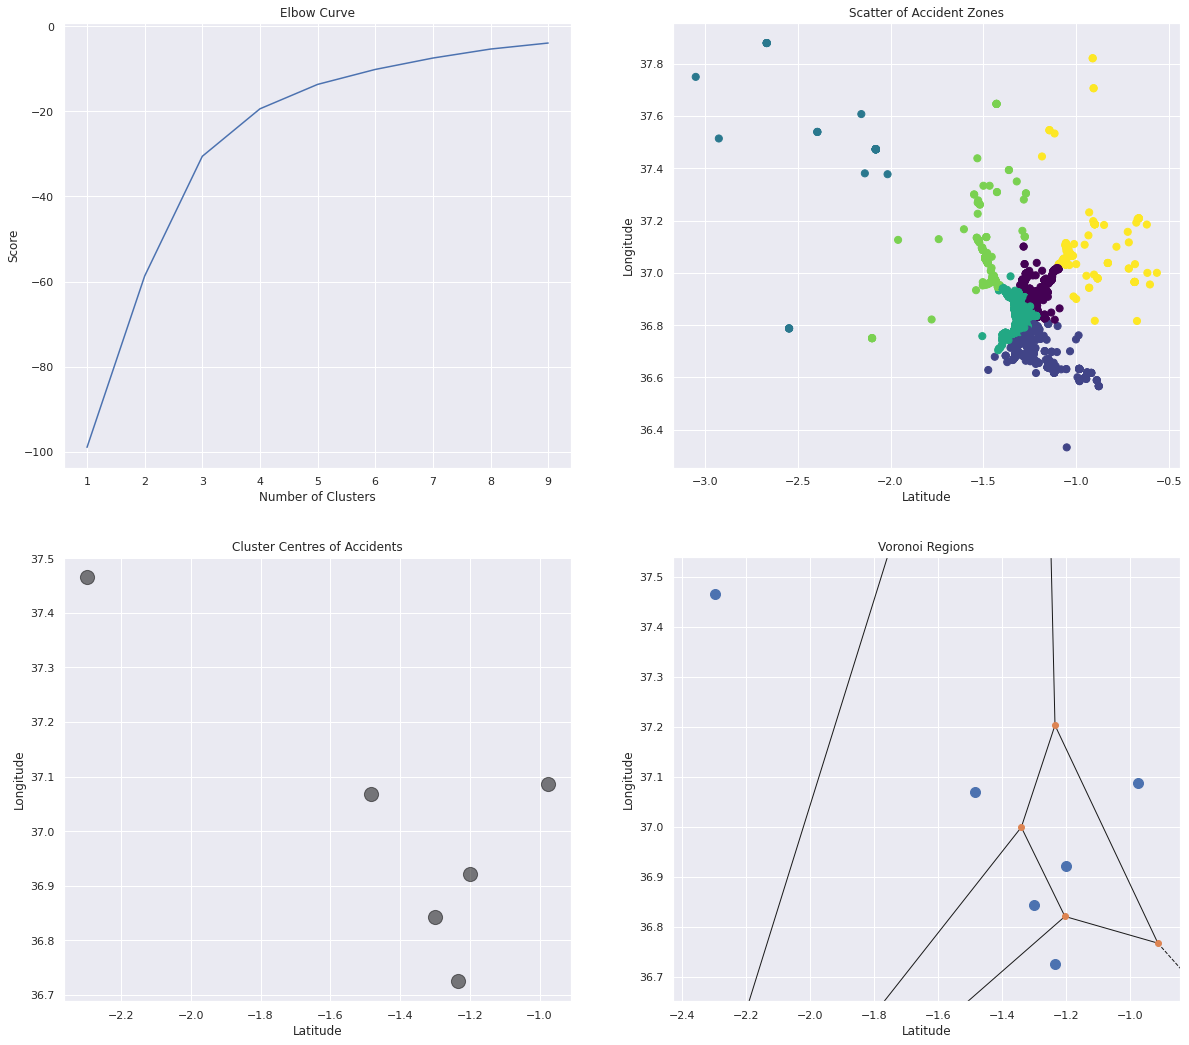

In [13]:
# clustering
K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = df[['latitude']]
X_axis = df[['longitude']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Variable with the Longitude and Latitude
X=df.loc[:,['datetime','latitude','longitude']]

kmeans = KMeans(n_clusters = 6, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point

# ===== clusters
#X.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')


# ===== road segments locations


fig, axs = plt.subplots(2, 2,figsize=(20, 18))
axs[0, 0].plot(K_clusters, score)
axs[0, 0].set_title('Elbow Curve')
axs[0, 0].set_ylabel('Score')
axs[0, 0].set_xlabel('Number of Clusters')

axs[1,0].scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5,cmap='viridis')
axs[1, 0].set_title('Cluster Centres of Accidents')
axs[1, 0].set_ylabel('Longitude')
axs[1, 0].set_xlabel('Latitude')

axs[0,1].scatter(x = X['latitude'], y = X['longitude'], c=labels, s=50, cmap='viridis')
axs[0, 1].set_title('Scatter of Accident Zones')
axs[0, 1].set_ylabel('Longitude')
axs[0, 1].set_xlabel('Latitude')

points = pd.DataFrame([centers[:, 0], centers[:, 1]]).transpose()
vor = Voronoi(points)

# plot
voronoi_plot_2d(vor,ax=axs[1,1],point_size=20)
axs[1, 1].set_title('Voronoi Regions')
axs[1, 1].set_ylabel('Longitude')
axs[1, 1].set_xlabel('Latitude')

In [10]:
len(centers)

5

In [11]:
# Variable with the Longitude and Latitude
X=df.loc[:,['datetime','latitude','longitude']]
X.head(10)

kmeans = KMeans(n_clusters = 6, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point

points['cluster_label'] = range(0,5)
points.columns = ['lat','lon','cluster_label']

point = points

merged = X.merge(point,on='cluster_label',how='left')
merged['hour'] = merged['datetime'].dt.hour

df_pd_3hours.columns = ['hour','idx']

mg = merged.merge(df_pd_3hours,on='hour',how='left')
mg.head()



,datetime,latitude,longitude,cluster_label,lat,lon,hour,idx
0,2018-01-01 00:25:46,-1.188850,36.931382,1,-2.269933,37.385892,0,296.0
1,2018-01-01 02:02:39,-0.662939,37.208730,3,-1.081659,37.015730,2,NaN
2,2018-01-01 02:31:49,-0.662939,37.208730,3,-1.081659,37.015730,2,NaN
3,2018-01-01 03:04:01,-1.288087,36.826583,0,-1.415377,36.998316,3,340.0
4,2018-01-01 03:58:49,-1.188850,36.931382,1,-2.269933,37.385892,3,340.0


In [93]:
df_pd_3hours.head()

,datetime,idx
0,0,296
1,3,340
2,6,1724
3,9,976
4,12,834


Rather than trying to predict accident locations or the number of accidents in a given timeframe, we are instead asked to come up with an ambulance deployment schedule that will minimise distance travelled. 

This is of course a simplification of the problem, but by solving this you will hopefully develop strategies that can be used going forward.

In [ ]:
# View the submission format
ss = pd.read_csv('SampleSubmission.csv', parse_dates=['date'])
ss.head()

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,2019-06-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0
1,2019-06-01 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0
2,2019-06-01 06:00:00,0,0,0,0,0,0,0,0,0,0,0,0
3,2019-06-01 09:00:00,0,0,0,0,0,0,0,0,0,0,0,0
4,2019-06-01 12:00:00,0,0,0,0,0,0,0,0,0,0,0,0


# Scoring

You can re-create the scoring process by creating your own test set and using the following function:

In [ ]:
def score(sub, ref):
    total_distance = 0
    for date, c_lat, c_lon in ref[['datetime', 'latitude', 'longitude']].values:
        row = sub.loc[sub.date < date].tail(1) # Prior to Oct 2 this was incorrectly .head(1)
        dists = []
        for a in range(6):
            dist = ((c_lat - row[f'A{a}_Latitude'].values[0])**2+(c_lon - row[f'A{a}_Longitude'].values[0])**2)**0.5 
            dists.append(dist)
        total_distance += min(dists)
    return total_distance


In [ ]:
# Example:

# Test set
reference = df.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set

# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')

# Create submission dataframe
sub = pd.DataFrame({
    'date':dates
})
for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = 0
    sub['A'+str(ambulance)+'_Longitude'] = 0

# Place an ambulance in the center of the city:
sub['A'+str(ambulance)+'_Latitude'] = 36.82
sub['A'+str(ambulance)+'_Longitude'] = -1.3



score(sub, reference)

70886.38526378157

This scoring function can be used for local testing without needing to submit on Zindi. Lower is better. Experiment with specifying set locations for all 6 ambulances, and see how low you can get your score.

# Weather Data

Some weatehr variables form the GFS dataset are provided, covering the greater Nairobi area. Let's take a quick look at the dataset before moving on:

In [ ]:
weather = pd.read_csv('Data/Weather_Nairobi_Daily_GFS.csv', parse_dates=['Date'])
weather.head()

,Date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground
0,2018-01-01,24.100000,72.700005,0.009560,15.161493,-0.012186,-0.933914
1,2018-01-02,27.362288,74.900002,0.010463,16.047998,0.314543,-0.485459
2,2018-01-03,30.246618,86.599998,0.011930,15.838525,-0.282732,-0.653965
3,2018-01-04,33.010689,90.900002,0.012780,16.169244,0.211572,0.908123
4,2018-01-05,27.250372,82.413353,0.011392,15.923456,1.047275,-0.037742


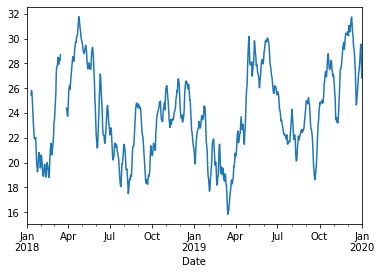

In [ ]:
# Interestingly, Kenya has two rainy seasons per year!
weather.set_index('Date')['precipitable_water_entire_atmosphere'].rolling(10).mean().plot()

# Road Survey Data

The road survey data contains many different measurements for each surveyed road segment. Unfortunately we can't access the raw data, and must work 'in the dark' in terms of what the column headings mean. However, the naming convention does at least show which columns may be related.

To locate the road segments geographically, a geojson file is provided. Here is an example of merging the survey data with the segments and visualizing the result.

In [ ]:
# Load the survey data
road_surveys = pd.read_csv('Data/Segment_info.csv')
road_surveys.head()

,segment_id,side,25_48,79_76,79_65,79_39,28_78_50,55_90,26_76,92_30,...,80_97_61_65_11,80_97_61_65_12,80_97_61_65_15,80_97_61_65_16,80_97_61_39_0,80_97_61_39_10,80_97_61_39_11,80_97_61_39_12,80_97_61_39_15,80_97_61_39_16
0,176_2,1,3,0,3,3,0.0,11,0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,176_2,2,3,0,3,3,0.0,11,0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,95_1,1,3,0,3,3,0.0,14,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,95_1,2,3,0,3,3,0.0,14,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,144_7,1,1,0,4,3,0.0,5,0,3,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# Load the map
road_segment_locs = gpd.read_file('Data/segments_geometry.geojson')
road_segment_locs.head()

,segment_id,road_name,geometry
0,28_1,accra road-tertiary,"LINESTRING (36.82603 -1.28447, 36.82605 -1.284..."
1,137_1,accra road-tertiary,"LINESTRING (36.82656 -1.28371, 36.82658 -1.283..."
2,137_2,accra road-tertiary,"LINESTRING (36.82711 -1.28289, 36.82713 -1.282..."
3,1_1,airport north road-primary,"LINESTRING (36.88646 -1.33284, 36.88649 -1.332..."
4,1_2,airport north road-primary,"LINESTRING (36.88726 -1.33226, 36.88729 -1.332..."


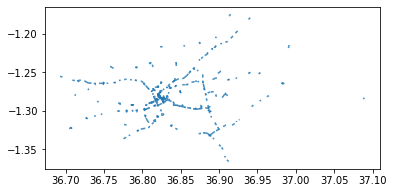

In [ ]:
# Because this is a geodataframe, we can plot it
road_segment_locs.plot()

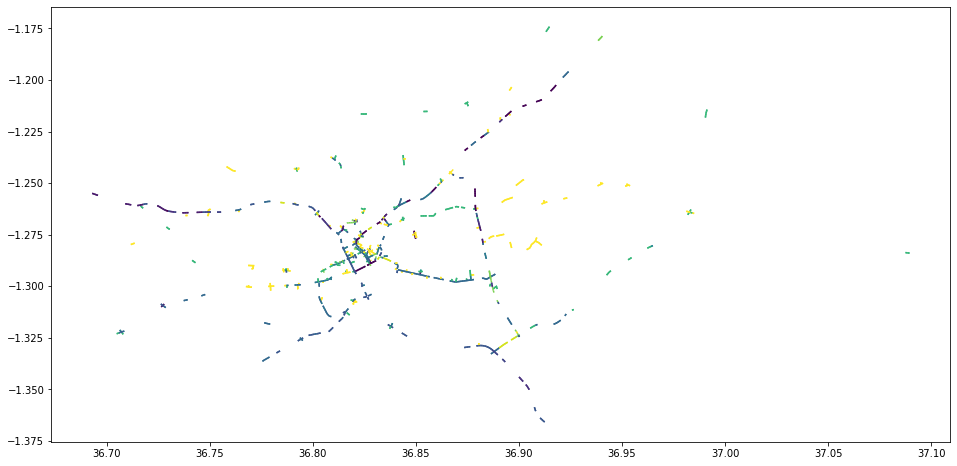

In [ ]:
# Let's merge the two and color by one of the survey columns
segments_merged = pd.merge(road_segment_locs, road_surveys, on='segment_id', how='left')
segments_merged.plot(column='55_90', figsize=(20, 8))

This data will come in useful if you're trying to predict the number of crashes along a particular road, or within a specified region. 

# Adding Uber Data

You can access speed data from https://movement.uber.com/explore/nairobi/speeds and clicking 'Download Data'. Here we'll load in the speeds from January 2019 and explore the data briefly.

In [ ]:
speeds = pd.read_csv('../uber_data/movement-speeds-hourly-nairobi-2019-1.csv', parse_dates=['utc_timestamp'])
speeds.head()

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osm_way_id,osm_start_node_id,osm_end_node_id,speed_kph_mean,speed_kph_stddev
0,2019,1,21,18,2019-01-21 15:00:00+00:00,41297ea07006246e330f9767862c5b85167eb37a,d97c55174d6c011dcd2bf3d1e05629b09dba739b,a996c01a24deb369c03c19b95b587a688ab2f9b8,8462710,3716534178,6287511790,20.025,5.147
1,2019,1,22,15,2019-01-22 12:00:00+00:00,41297ea07006246e330f9767862c5b85167eb37a,d97c55174d6c011dcd2bf3d1e05629b09dba739b,a996c01a24deb369c03c19b95b587a688ab2f9b8,8462710,3716534178,6287511790,20.572,11.282
2,2019,1,8,17,2019-01-08 14:00:00+00:00,41297ea07006246e330f9767862c5b85167eb37a,d97c55174d6c011dcd2bf3d1e05629b09dba739b,a996c01a24deb369c03c19b95b587a688ab2f9b8,8462710,3716534178,6287511790,17.325,3.055
3,2019,1,12,21,2019-01-12 18:00:00+00:00,41297ea07006246e330f9767862c5b85167eb37a,d97c55174d6c011dcd2bf3d1e05629b09dba739b,a996c01a24deb369c03c19b95b587a688ab2f9b8,8462710,3716534178,6287511790,19.284,2.032
4,2019,1,14,9,2019-01-14 06:00:00+00:00,41297ea07006246e330f9767862c5b85167eb37a,d97c55174d6c011dcd2bf3d1e05629b09dba739b,a996c01a24deb369c03c19b95b587a688ab2f9b8,8462710,3716534178,6287511790,19.827,3.316


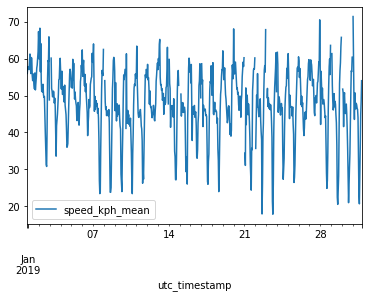

In [ ]:
# Plot speeds over time for a specific OSM way
way = speeds.loc[speeds.osm_way_id == 133901081]
way = way.set_index('utc_timestamp')
way.resample('1h').mean().plot(y='speed_kph_mean')

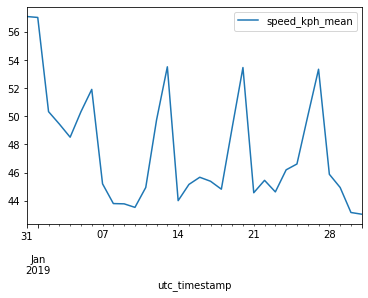

In [ ]:
way.resample('1D').mean().plot(y='speed_kph_mean')

You can use any and all data available through Uber Movement, including linking the speeds data to OSM segments, downloading quarterly statistics, using the Movement Data Toolkit etc.

You can find much more info about working with the speeds data here: https://medium.com/uber-movement/working-with-uber-movement-speeds-data-cc01d35937b3 - including how to link the segment_id with OSM data

# What Next?

There are many ways you could approach this challenge. For example, you could:
- Create a model to predict the liklihood of an accident given a location, the features of the nearby road segments, the weather, the traffic speed and the time of day
- Use this model to predict the probability of crashes for different times+locations over the test period, and then sample from this probability distribution to generate plausible crash locations.
- Use an optimization technique to minimise the travel distance for the ambulances to your fake crash points. 

This might seem too complicated - perhaps simply picking 6 fixed locations based on the existing data will be enough? Or maybe it's worth setting separate locations during busy traffic times? 

Perhaps a Reinforcement Learning aproach will do well? 

Or maybe you can see a totally different way to solve this!

Share your ideas on the discussion boards, and let's see how innovative we can be :)